In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

### Import data

In [2]:
def strip_months(x):
    return x.strip('months').strip()

In [3]:
def p2f(x):
    return x.strip('%')

In [4]:
def strip_years(x):
    return re.sub(r'years|year','',x).strip()


In [5]:
loan_data = pd.read_csv("C:\\Users\\User\\Desktop\\HappyMoney\\LoanStats_2015.csv", sep=',',header=1,
                        skiprows=0, nrows=421095, 
                        converters={'int_rate':p2f,'revol_util':p2f,'term':strip_months,'emp_length':strip_years},
                        parse_dates=["last_pymnt_d","next_pymnt_d","last_credit_pull_d","debt_settlement_flag_date","settlement_date","issue_d","earliest_cr_line","hardship_start_date","hardship_end_date","payment_plan_start_date"],
                       low_memory=False)

#revol_util,term,int_rate 
loan_data[['revol_util','int_rate']] = loan_data[['revol_util','int_rate']].apply(pd.to_numeric,downcast='float')                                

In [6]:
loan_data.head(2)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,12000,12000,12000.0,60,9.80,253.79,B,B3,...,NaN,NaN,Cash,N,NaT,NaN,NaT,NaN,NaN,NaN
1,NaN,NaN,25000,25000,25000.0,36,5.32,752.87,A,A1,...,NaN,NaN,Cash,N,NaT,NaN,NaT,NaN,NaN,NaN


### drop columns with not even single value

In [7]:
missing_df = loan_data.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.loc[missing_df['missing_count']==loan_data.shape[0]]
drop_cols=missing_df.column_name.values.tolist()
print("shape of loan_data before:",loan_data.shape)
loan_data=loan_data.drop(drop_cols,axis=1)
print("shape of loan_data after:",loan_data.shape)

shape of loan_data before: (421095, 145)
shape of loan_data after: (421095, 131)


### drop columns with 1 constant value

In [8]:
# has only constant value for all the records
print("shape of loan_data before:",loan_data.shape)
loan_data=loan_data.drop(["disbursement_method","policy_code"],axis=1) 
print("shape of loan_data after:",loan_data.shape)

shape of loan_data before: (421095, 131)
shape of loan_data after: (421095, 129)


### Optimizing dataframe memory usage

In [9]:
loan_data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421095 entries, 0 to 421094
Columns: 129 entries, loan_amnt to settlement_term
dtypes: datetime64[ns](10), float32(2), float64(54), int64(39), object(24)
memory usage: 863.5 MB


In [10]:
for dtype in ['float32','float64','int64','object','datetime64']:
    selected_dtype = loan_data.select_dtypes(include=[dtype])
    mean_usage_b = selected_dtype.memory_usage(deep=True).mean()
    mean_usage_mb = mean_usage_b / 1024 ** 2
    print("Average memory usage for {} columns: {:03.2f} MB".format(dtype,mean_usage_mb))

Average memory usage for float32 columns: 1.07 MB
Average memory usage for float64 columns: 3.15 MB
Average memory usage for int64 columns: 3.13 MB
Average memory usage for object columns: 21.17 MB
Average memory usage for datetime64 columns: 2.92 MB


In [11]:
# utility for calculating memory usage
def mem_usage(pandas_obj):
    if isinstance(pandas_obj,pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else: # we assume if not a df it's a series
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2 # convert bytes to megabytes
    return "{:03.2f} MB".format(usage_mb)

#### Optimizing integer columns

In [12]:
loan_data_copy=loan_data.copy()
loan_data_int = loan_data.select_dtypes(include=['int64'])
loan_data_int.shape

(421095, 39)

In [13]:
converted_loan_data_int = loan_data_int.apply(pd.to_numeric,downcast='unsigned')
print(mem_usage(loan_data_int))
print(mem_usage(converted_loan_data_int))
loan_data_copy[converted_loan_data_int.columns] = converted_loan_data_int
compare_ints = pd.concat([loan_data_int.dtypes,converted_loan_data_int.dtypes],axis=1)
compare_ints.columns = ['before','after']
compare_ints.apply(pd.Series.value_counts)

125.30 MB
29.72 MB


,before,after
uint8,NaN,24.0
uint16,NaN,5.0
uint32,NaN,10.0
int64,39.0,NaN


#### Optimizing float columns

In [14]:
loan_data_float = loan_data.select_dtypes(include=['float32','float64'])
loan_data_float.shape

(421095, 56)

In [15]:
converted_loan_data_float = loan_data_float.apply(pd.to_numeric,downcast='float')
print(mem_usage(loan_data_float))
print(mem_usage(converted_loan_data_float))
loan_data_copy[converted_loan_data_float.columns] = converted_loan_data_float

compare_floats = pd.concat([loan_data_float.dtypes,converted_loan_data_float.dtypes],axis=1)
compare_floats.columns = ['before','after']
compare_floats.apply(pd.Series.value_counts)

176.70 MB
89.96 MB


,before,after
float32,2,56.0
float64,54,NaN


#### Before vs After Optimization

In [16]:
print("Before",mem_usage(loan_data))
print("After",mem_usage(loan_data_copy))

Before 863.48 MB
After 681.16 MB


#### SET A:  What is the monthly total loan volume in dollars ?


In [17]:
#loan_amnt , issue_m
loan_data_copy['issue_m'] = loan_data_copy['issue_d'].dt.month
temp_df1 = loan_data_copy[['issue_m','loan_amnt']]
r1=temp_df1.groupby("issue_m").sum().reset_index()
r1

,issue_m,loan_amnt
0,1,533132575.0
1,2,366908525.0
2,3,390003275.0
3,4,539401075.0
4,5,483189475.0
5,6,429777175.0
6,7,696238600.0
7,8,555331400.0
8,9,450246800.0
9,10,738221400.0


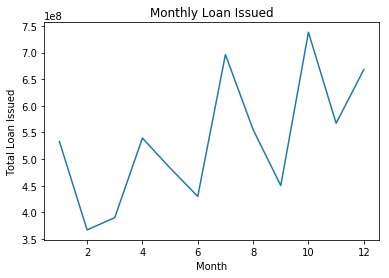

In [18]:
fig, ax = plt.subplots()
ax.set_xlabel('Month')
ax.set_ylabel('Total Loan Issued')
ax.set_title('Monthly Loan Issued')
plt.xscale('linear')
plt.plot(r1.issue_m,r1.loan_amnt)

#### SET A: what is the monthly average loan size?

In [19]:
#what is the monthly total loan volume in dollars 
r2=temp_df1.groupby("issue_m").mean().reset_index()
r2

,issue_m,loan_amnt
0,1,15185.933717
1,2,15435.781447
2,3,15354.459646
3,4,15225.705676
4,5,15140.835240
5,6,15087.841847
6,7,15148.135416
7,8,15474.875996
8,9,15720.358926
9,10,15180.057988


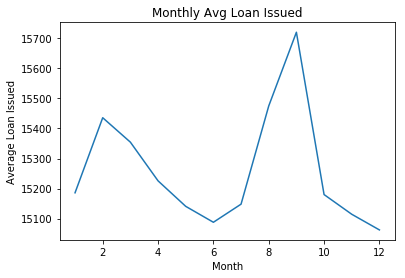

In [20]:
fig, ax = plt.subplots()
ax.set_xlabel('Month')
ax.set_ylabel('Average Loan Issued')
ax.set_title('Monthly Avg Loan Issued')
plt.xscale('linear')
plt.plot(r2.issue_m,r2.loan_amnt)

#### SET A: What are the default rates by Loan Grade?


In [21]:
def default_rate(loan_status_group):
    # input is a DataFrame of group values
    n_defaults=len(loan_status_group.loc[loan_status_group.loan_status=="Default"])
    n_total = len(loan_status_group)
    return (n_defaults/n_total)*100
    


r3 = loan_data_copy[["loan_status","grade"]]
r3 = r3.groupby(["grade"]).apply(default_rate).reset_index()
r3.columns = ['grade', 'default_rate']
r3
            


,grade,default_rate
0,A,0.001364
1,B,0.000850
2,C,0.003318
3,D,0.001596
4,E,0.005723
5,F,0.000000
6,G,0.000000


#### SET A: Is Lending Club charging an appropriate interest rate for the risk?


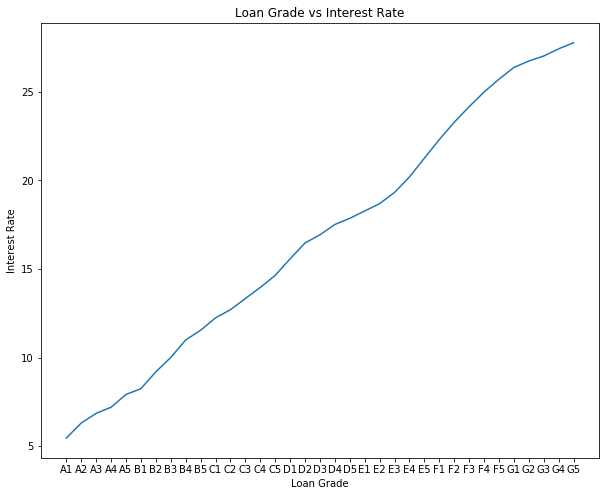

In [22]:
r4 = loan_data_copy[["int_rate","sub_grade"]]
r4 = r4.groupby(["sub_grade"]).mean().reset_index()
r4 = r4.sort_values(by='int_rate')
fig, ax = plt.subplots(figsize=(10,8))
ax.set_xlabel('Loan Grade')
ax.set_ylabel('Interest Rate')
ax.set_title('Loan Grade vs Interest Rate')
plt.plot(r4.sub_grade,r4.int_rate)

#### The above graph shows increase in interest rate with increase in risk factor associated with the loan. Hence we could say that lending club is charging an appropriate interest rate for the risk

#### Set B

-  Data is often messy please review and QA the dataset and summarize your thoughts on any structural
issues:
    -  Is there missing data? Is the missing data random or structured? Are some attributes missing more
than others?
   

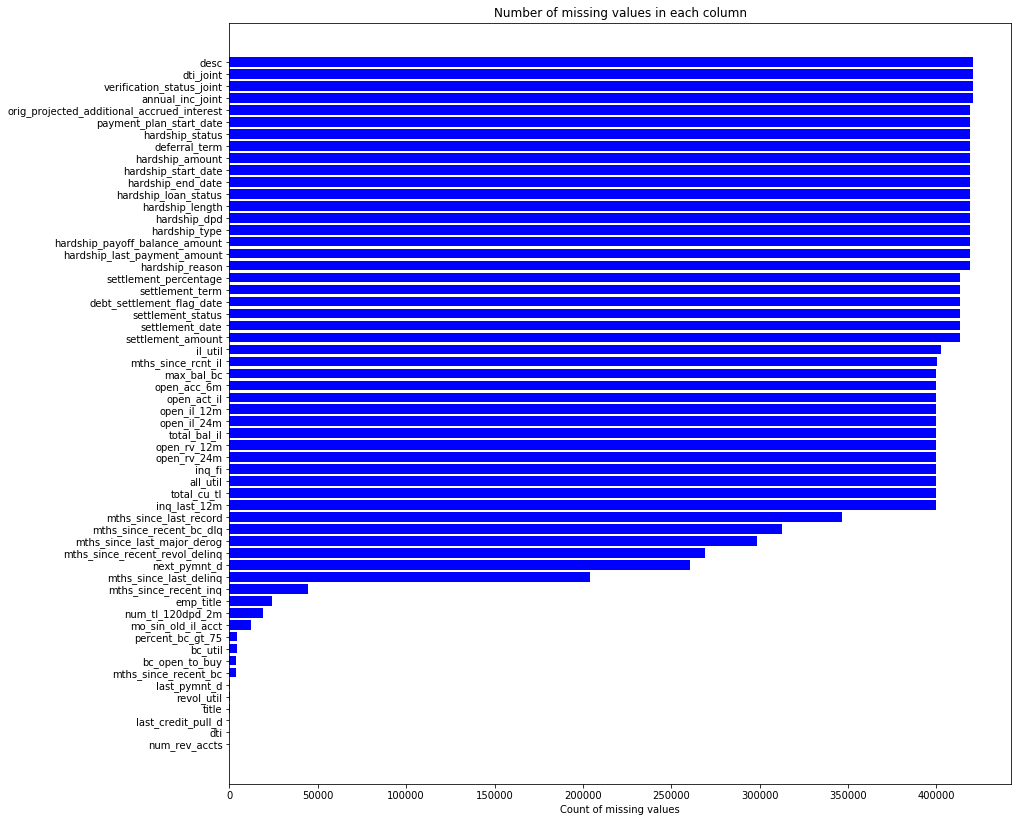

In [23]:
missing_df = loan_data_copy.isnull().sum(axis=0).reset_index()
missing_df.columns = ['variable_name', 'missing_count']
missing_df = missing_df.loc[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')
missing_df_copy=missing_df.copy()
ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(14,14))
rects = ax.barh(ind, missing_df.missing_count.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.variable_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

In [24]:
print("total number of variables: ",loan_data_copy.shape[1])
print("total number of variables with missing values:",missing_df.shape[0])

total number of variables:  130
total number of variables with missing values: 58


### Let's check hardship related variables

    -  hardship_amount
    -  hardship_dpd  
    -  hardship_end_date
    -  hardship_last_payment_amount
    -  hardship_length
    -  hardship_loan_status
    -  hardship_payoff_balance_amount
    -  hardship_reason
    -  hardship_start_date
    -  hardship_status
    -  hardship_type
    -  payment_plan_start_date
    -  deferral_term

In [25]:
temp_df = loan_data_copy[["hardship_amount","hardship_dpd","hardship_last_payment_amount","hardship_length","hardship_loan_status","hardship_payoff_balance_amount",
"hardship_reason","hardship_start_date","hardship_end_date","hardship_status","hardship_type","hardship_flag","deferral_term","payment_plan_start_date"]]
temp_df =temp_df.isnull().sum().reset_index()
temp_df.columns=["varibale","missing count"]
print("total # of records:",len(loan_data_copy))
print(temp_df)

total # of records: 421095
                          varibale  missing count
0                  hardship_amount         418981
1                     hardship_dpd         418981
2     hardship_last_payment_amount         418981
3                  hardship_length         418981
4             hardship_loan_status         418981
5   hardship_payoff_balance_amount         418981
6                  hardship_reason         418981
7              hardship_start_date         418981
8                hardship_end_date         418981
9                  hardship_status         418981
10                   hardship_type         418981
11                   hardship_flag              0
12                   deferral_term         418981
13         payment_plan_start_date         418981


In [26]:
print("total records",loan_data_copy.hardship_status.value_counts().sum())
loan_data_copy.hardship_status.value_counts()

missing_df =missing_df.loc[~missing_df.variable_name.isin(["hardship_amount","hardship_dpd","hardship_flag","hardship_last_payment_amount","hardship_length","hardship_loan_status","hardship_payoff_balance_amount",
"hardship_reason","hardship_start_date","hardship_end_date","hardship_status","hardship_type","deferral_term","payment_plan_start_date"])]


total records 2114


### Observation on hardship related variables

-  From the analysis, I understood that the hardship records are maintained only for loans/people with hardship_status values "COMPLETED","BROKEN","ACTIVE".

-  All the other records doesn't have values for any of the hardship related variables

-  Exception: hardship_flag variable which maintains a value of "Yes" for loans with hardship_status "ACTIVE" and "No" for all other loans

-  Hence, these are not actually missing values. Also zero cannot be a valid default value for all these variables. Have to come up with a default value for all the above variables before feeding the data into a prediction model

### verification_status_joint, annual_inc_joint, dti_joint

In [27]:
print("annual_inc_joint :",loan_data_copy.annual_inc_joint.value_counts().sum(),"\n")
print("dti_joint :",loan_data_copy.dti_joint.value_counts().sum(),"\n")
print("application_type val count:",loan_data_copy.application_type.value_counts(),"\n")
print("verification_status_joint value count:",loan_data_copy.verification_status_joint.value_counts(),"\n")
#temp5=loan_data_copy.loc[loan_data_copy.application_type=="Joint App", ["verification_status_joint","application_type"]]
#print("no null",temp5.isnull().sum())
#temp6=loan_data_copy.loc[loan_data_copy.application_type=="Joint App", ["annual_inc_joint","application_type"]]
#temp6.isnull().sum()
missing_df =missing_df.loc[~missing_df.variable_name.isin(["verification_status_joint","annual_inc_joint","dti_joint"])]

annual_inc_joint : 511 

dti_joint : 509 

application_type val count: Individual    420584
Joint App        511
Name: application_type, dtype: int64 

verification_status_joint value count: Not Verified    511
Name: verification_status_joint, dtype: int64 



### Observation on verification_status_joint,annual_inc_joint

-  verification_status_joint is a variable related to Joint application, and there are only 511 joint application in the give dataset and verification_status_joint has values for the 511 records
- same reason applies for annual_inc_joint
- same reason applies for dti_joint but this variable has 2 missing values
- Hence there are no missing values in this column

### Let's check settlement related variables

-  debt_settlement_flag
-  settlement_amount
-  settlement_date
-  settlement_status
-  debt_settlement_flag_date
-  settlement_term
-  settlement_percentage

In [28]:
temp_df = loan_data_copy[["debt_settlement_flag","settlement_amount","settlement_date","settlement_status","debt_settlement_flag_date",
                         "settlement_term","settlement_percentage"]]

temp_df =temp_df.isnull().sum().reset_index()
temp_df.columns=["varibale","missing count"]
print("debt_settlement_flag value_counts:",loan_data_copy.debt_settlement_flag.value_counts(),"\n")
print("total # of records:",len(loan_data_copy))
print(temp_df)

missing_df =missing_df.loc[~missing_df.variable_name.isin(["debt_settlement_flag","settlement_amount","settlement_date","settlement_status","debt_settlement_flag_date",
                         "settlement_term","settlement_percentage"])]

debt_settlement_flag value_counts: N    413697
Y      7398
Name: debt_settlement_flag, dtype: int64 

total # of records: 421095
                    varibale  missing count
0       debt_settlement_flag              0
1          settlement_amount         413697
2            settlement_date         413697
3          settlement_status         413697
4  debt_settlement_flag_date         413697
5            settlement_term         413697
6      settlement_percentage         413697


### Observation on settlement related variables

-  From the analysis, I understood that the settlement records are maintained only for loans/people with debt_settlement_flag value "Yes"

-  All the other records doesn't have values for any of the settlement related variables

-  Hence, these are not actually missing values. Also zero cannot be a valid default value for all these variables. Have to come up with a default value for all the above variables before feeding the data into a prediction model

### Let's check installement account related variables

    -  mo_sin_old_il_acct
    -  open_act_il
    -  mths_since_rcnt_il
    -  num_il_tl
    -  open_il_12m
    -  open_il_24m
    -  total_bal_il
    -  total_il_high_credit_limit


In [29]:
temp10=loan_data_copy[["mo_sin_old_il_acct","open_act_il","mths_since_rcnt_il","num_il_tl","open_il_12m","open_il_24m","total_bal_il"]]

temp10.isnull().sum()

mo_sin_old_il_acct     12254
open_act_il           399723
mths_since_rcnt_il    400285
num_il_tl                  0
open_il_12m           399723
open_il_24m           399723
total_bal_il          399723
dtype: int64

In [30]:
temp10 =temp10.loc[(temp10.mths_since_rcnt_il.isnull() & temp10.total_bal_il.isnull() & temp10.open_il_24m.isnull() & temp10.open_il_12m.isnull() & temp10.open_act_il.isnull()  )]
temp10.shape
missing_df =missing_df.loc[~missing_df.variable_name.isin( ["mo_sin_old_il_acct","open_act_il","mths_since_rcnt_il","num_il_tl","open_il_12m","open_il_24m","total_bal_il"])]

###  Observation on installement account related variables

-  From the analysis, all the above variables are missing values in the same 399723 records. While there is a pattern is missing data, there appears to be no reason why the data is missing

### Let's look at  revolving account and trade related variables

    -  num_op_rev_tl
    -  num_actv_rev_tl
    -  open_rv_12m
    -  open_rv_24m
    -  bc_open_to_buy
    -  max_bal_bc
    -  mo_sin_old_rev_tl_op
    -  num_rev_accts
    -  num_rev_tl_bal_gt_0
    -  revol_bal
    -  mo_sin_rcnt_rev_tl_op
    -  revol_bal_joint 
    -  revol_util
    -  all_util
    -  total_cu_tl
    -  open_acc_6m


In [31]:
temp10=loan_data_copy[["num_rev_accts","num_op_rev_tl","mo_sin_old_rev_tl_op","num_actv_rev_tl","open_rv_12m",
                      "open_rv_24m","bc_open_to_buy","max_bal_bc","num_rev_tl_bal_gt_0","revol_bal","revol_util","all_util","total_cu_tl","open_acc_6m"]]

missing_df =missing_df.loc[~missing_df.variable_name.isin(["num_rev_accts","num_op_rev_tl","mo_sin_old_rev_tl_op","num_actv_rev_tl","open_rv_12m",
                      "open_rv_24m","bc_open_to_buy","max_bal_bc","num_rev_tl_bal_gt_0","revol_bal","revol_util","all_util","total_cu_tl","open_acc_6m"])]
temp10.isnull().sum()

num_rev_accts                1
num_op_rev_tl                0
mo_sin_old_rev_tl_op         0
num_actv_rev_tl              0
open_rv_12m             399723
open_rv_24m             399723
bc_open_to_buy            3963
max_bal_bc              399723
num_rev_tl_bal_gt_0          0
revol_bal                    0
revol_util                 162
all_util                399723
total_cu_tl             399723
open_acc_6m             399723
dtype: int64

### Observation on revolving account and trade related variables
-  From the analysis, all the above variables are missing values in the same 399723 records. While there is a pattern is missing data, there appears to be no reason why the data is missing

-  Removing all the variables with less than 2% missing vales


In [32]:
missing_df = missing_df.loc[(missing_df['missing_count']>0.02*loan_data_copy.shape[0])]

-  Removing all the variables with more than 95% missing vales since imputation will only add noise to the data

In [33]:
missing_df = missing_df.loc[(missing_df['missing_count']<0.95*loan_data_copy.shape[0])]


### Let's look at emp_title & emp_length variables

In [34]:
temp12 =loan_data_copy.emp_length.value_counts().reset_index()
print("# NA's in emp_length:",temp12.iloc[7].values)
print("# NA's in emp_length:",loan_data_copy.emp_title.isnull().sum())

# NA's in emp_length: ['n/a' 23817]
# NA's in emp_length: 23874


In [35]:
missing_df =missing_df.loc[~missing_df.variable_name.isin( ["emp_title"])]

### Observation
-  The number of NA values in both emp_title and emp_length are nearly equal and the values appear to be missing at random

### Rest of the variables

    -  num_tl_120dpd_2m
------------------------------------------    
    -  mths_since_recent_inq
    -  inq_last_12m
    -  inq_fi
------------------------------------------
    -  mths_since_last_delinq
    -  mths_since_recent_bc_dlq
    -  mths_since_recent_revol_delinq
    -  mths_since_last_major_derog
-------------------------------------------
    -  mths_since_last_record
    -  next_pymnt_d

- These variables also seems to be missing values randomly


#### SET B: Outliers !!!
 -  Are there any glaringly erroneous data values?

In [36]:
#### All integer columns

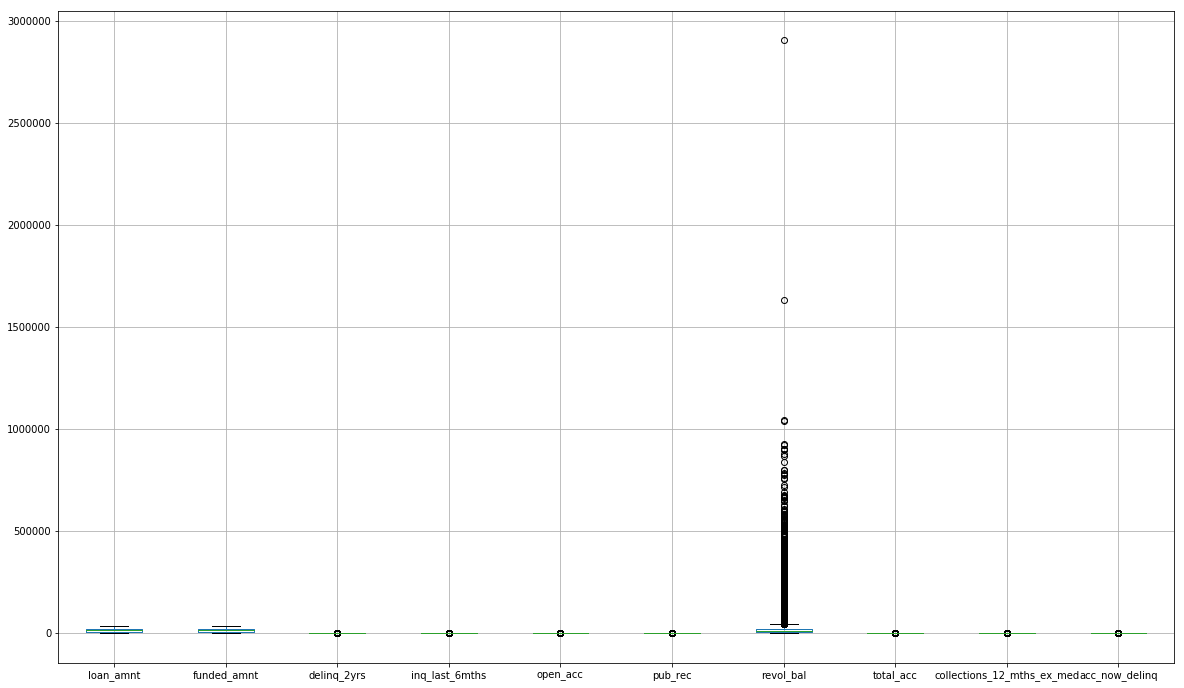

In [37]:
fig, ax = plt.subplots(figsize=(20,12))
loan_data_int.iloc[:,0:10].boxplot()

####  revol_bal variable seems to have some outliers

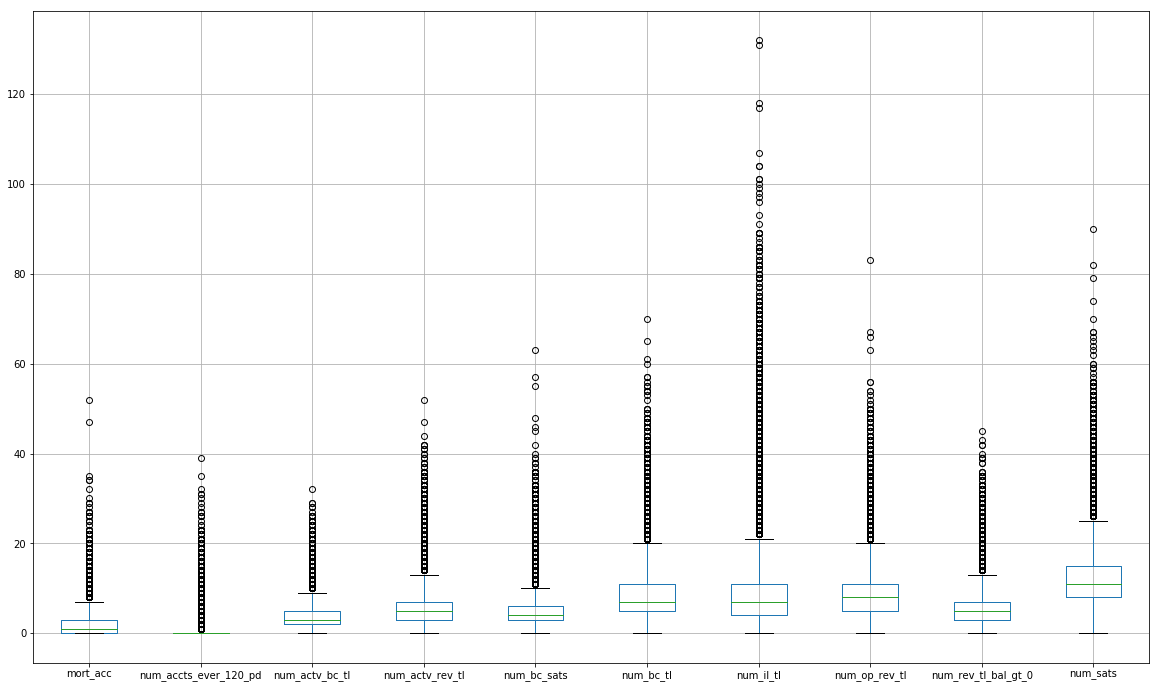

In [38]:
fig, ax = plt.subplots(figsize=(20,12))
loan_data_int.iloc[:,20:30].boxplot()

#### Almost all the variables in the above plots seems to have few outliers

#### SET A What are some of the predictors of loan default?

In [39]:
# removing all the variables with missing values
temp_df =loan_data_copy[loan_data_copy.columns.difference(missing_df_copy.variable_name.values.tolist())]
temp_df.shape

(421095, 72)

In [40]:
# create dummies for categorical variables
dummies_list=['debt_settlement_flag','pymnt_plan','hardship_flag','application_type','home_ownership','initial_list_status','term','verification_status',
             'grade','purpose']
dummy_df = pd.get_dummies(loan_data[dummies_list])
temp_df[dummy_df.columns] = dummy_df
temp_df=temp_df.drop(dummies_list,axis=1)


C:\Users\User\Anaconda3\lib\site-packages\pandas\core\frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [41]:
## remove object and datetime64 datatypes which the xgboost algorithm can't handle
loan_data_object = temp_df.select_dtypes(include=['object',"datetime64"])
rm_list = loan_data_object.columns.tolist()
temp_df =temp_df[temp_df.columns.difference(rm_list)]
temp_df.shape

(421095, 95)

In [42]:
import xgboost as xgb
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
ty=le.fit_transform(loan_data_copy.loan_status)
train_X = temp_df
train_Y = ty
xg_train = xgb.DMatrix(train_X, label=train_Y,feature_names=train_X.columns.values)

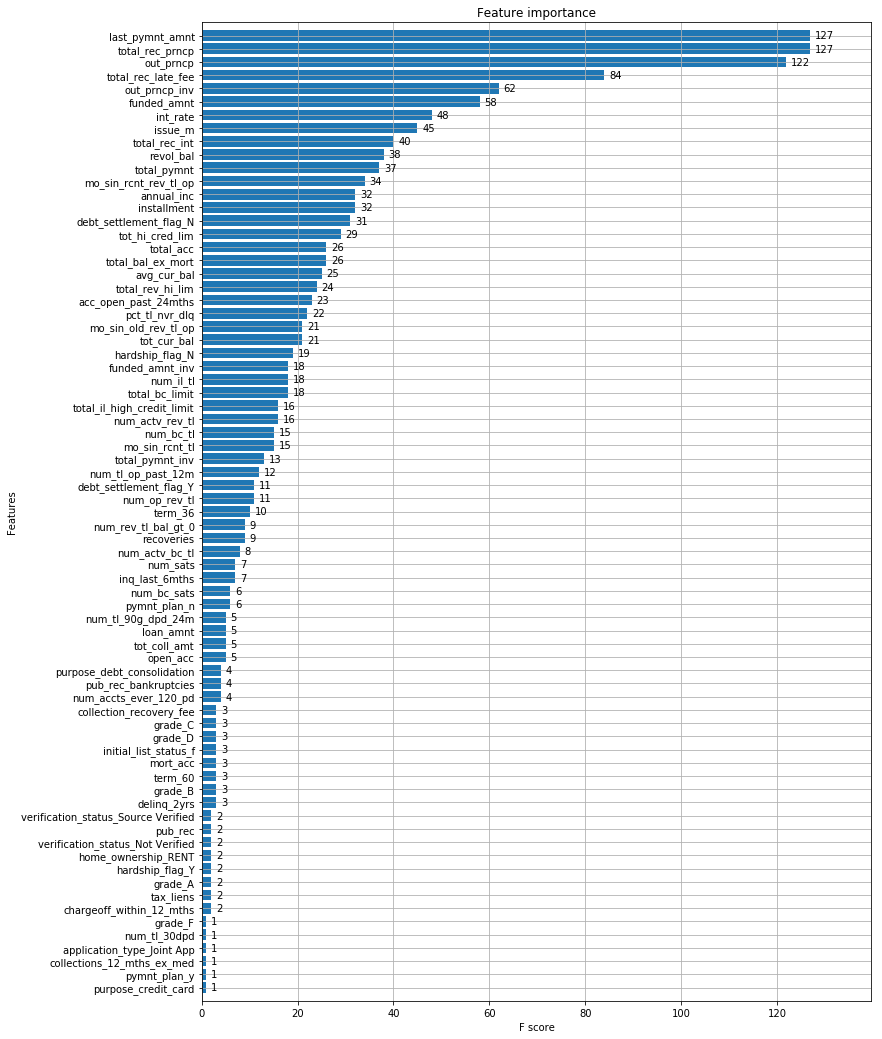

In [43]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'nthread':4,
    'objective': 'multi:softmax',
    'num_class':7,
    'silent': 1,
    'seed' : 31
}

model = xgb.train(dict(xgb_params), xg_train, num_boost_round=5)
# plot the important features #
fig, ax = plt.subplots(figsize=(12,18))
#max_num_features=50, error for no reason 
xgb.plot_importance(model, height=0.8, ax=ax)
plt.show()

#### top candidates to predict loan status

    -  last_paymnt_amnt
    -  total_rec_prncp
    -  total_rec_late_fee
    -  out_prncp
    -  funded_amnt
    -  int_rate
    -  issue_m

-  In general one would expect some of applicant related variables like annual income, home ownership to come on top of this list, but I believe those didn't come up as top features as the dataset has only 9 default cases


#### SET B-  Topic: Principal Component Analysis
 

#### Someone with little mathematical experience.

PCA is just a method of summarizing some data. 

-  Let's we have some wine bottles standing here on the table. We can describe each wine by its colour, by how strong it is, by how old it is, and so on. We can compose a whole list of different characteristics of each wine. But many of them will measure related properties and so will be redundant. If so, we should be able to summarize each wine with fewer characteristics.
This is what PCA does.

a) How does PCA achieve it?

-  does it discard all the redundant properties?  No. Instead, it constructs some new characteristics that summarizes the list of wines very well. The new characteristics are constructed using the linear combinations of old ones. PCA selects the best linear combinations that summarizes the list of wines as well as possible.

-  the selected new characteristics will have 2 properties and both are achieved in one step :

    -  have maximum variance. (variance - measure of ability to explain the data)
    -  ability to be able reconstruct the original characteristics as close as possible


#### Someone with significant mathematical experience.

-  Assuming this person has read the previous explanation 

b) and asks how PCA achieves the 2 properties together in 1 step  ?

-  Assume 2 correlated wine characteristics. Here is what a scatter plot of different wines could look like:


-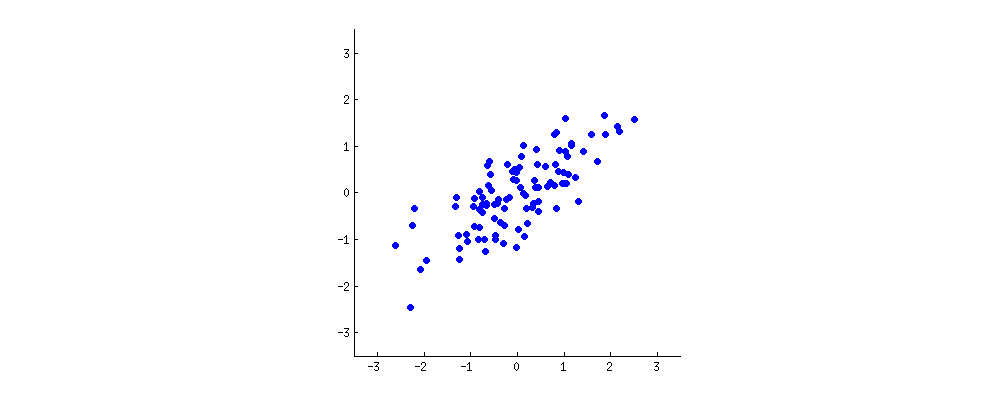


-  Each dot in this "wine cloud" shows one particular wine. A new property can be constructed by drawing a line through the center of this wine cloud and projecting all points onto this line. This new property will be given by a linear combination w1x+w2y, where each line corresponds to some particular values of w1 and w2.

-  here is how these projections look like for different lines (red dots are projections of the blue dots)

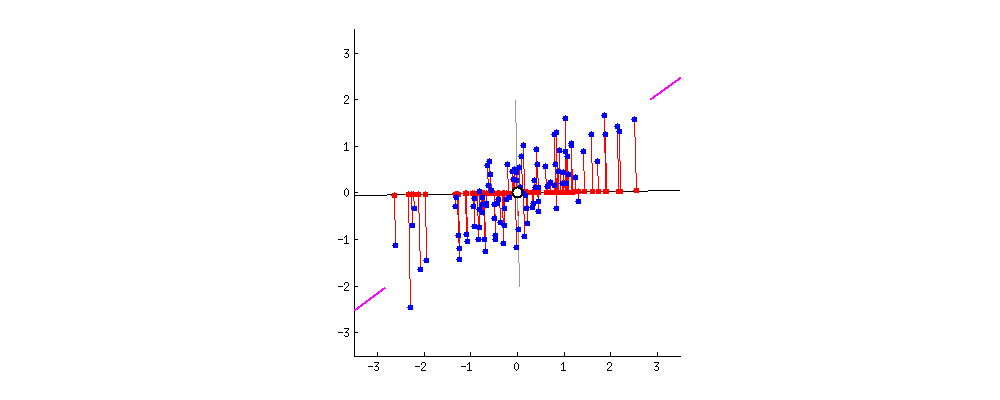

-  First, the variation of values along this line should be maximal. 
    
    -  Pay attention to how the variance of the red dots changes while the line rotates, it reaches reaches maximum when the new axis aligns with the points

-  Second we need to able reconstruct the original two characteristics 

    -  The reconstruction error will be given by the length of the connecting red line. Observe how the length of these red lines changes while the line rotates; it reaches reaches minimum when the new axis aligns with the points

-  As we notice that the maximum variance and the minimum error are reached at the same time, namely when the line points to the magenta ticks I marked on both sides of the wine cloud. This line corresponds to the new wine property that will be constructed by PCA.


c) how PCA is related to eigenvectors and eigenvalues?

-  Imagine that we compose a square matrix of numbers that describe the variance of the data, and the covariance among variables. This is the covariance matrix

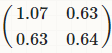

-  In the above matrix, the variance of the x variable is 1.07, the variance of the y variable is 0.64, and the covariance between them is 0.63.

-  As it is a square symmetric matrix, it can be diagonalized by choosing a new orthogonal coordinate system, given by its eigenvectors and the corresponding eigenvalues located on the diagonal. In this new coordinate system, the covariance matrix is diagonal and looks like

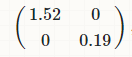

-  the variance of the new projection will be given by a weighted average of the eigenvalues

-  Eigenvalues = variance of the data along a particular axis in the new coordinate system. 
-  Eigenvectors = the vectors which represent the new coordinate system.